# I )  Exploration des données

L'objectif est de corriger les Codes Fedas d'une entreprise. Pour rappel, un code Fedas correspond, à une identification des produits selon leurs attributs. Ici, certains codes FEDAS sont erronés menant à une un mauvais référencement de la marchandise. A nous des les corriger. 

#### 1 ) Compréhension des données.  

-   Les données ont deux types de séparateurs différents
-   Des valeurs manquantes, icompris parmis les FEDAS incorrects. 
-   Tous les FEDAS code sont faux. 
-   1469 codes différents. 
-   Globalement une grande cardinalité au sein des variables qu'il faudra réduire pour éviter d'overfit. 

Pour réduire la cardinalité nous travaillerons avec une "connaissance métier". Par exemple nous remplacerons les variables "LOISIR" par "LOISIRS" afin d'uniformiser le jeu de donnée et de réduire la cardinalité de l'ensemble.


In [1]:
import pandas as pd
import io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score

In [29]:
file_path='train_technical_test.csv'

In [37]:
# Ouvrons le fichier en mode lecture et chargons le contenu dans une variable
with open(file_path, 'r', encoding='utf-8') as file:
    file_content = file.read()

# Remplacons toutes les virgules par des points-virgules
modified_content = file_content.replace(',', ';')

# Utilisons StringIO pour convertir la chaîne de texte en un objet fichier-like et lisons avec Pandas
buffer = io.StringIO(modified_content)
df = pd.read_csv(buffer, sep=';')

In [4]:
# Vérifie la structure, les types de données et les valeurs manquantes du jeu de données
df_info = df.info()
# Vérifie le nombre de valeurs manquantes dans chaque colonne
missing_values = df.isnull().sum()
df_info, missing_values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39322 entries, 0 to 39321
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   brand                      39322 non-null  object 
 1   model_code                 39322 non-null  object 
 2   model_label                39322 non-null  object 
 3   commercial_label           6238 non-null   object 
 4   incorrect_fedas_code       28468 non-null  float64
 5   article_main_category      38571 non-null  object 
 6   article_type               38402 non-null  object 
 7   article_detail             29622 non-null  object 
 8   comment                    1552 non-null   object 
 9   avalability_start_date     24908 non-null  float64
 10  avalability_end_date       22004 non-null  float64
 11  length                     39322 non-null  float64
 12  width                      39322 non-null  float64
 13  height                     39322 non-null  flo

(None,
 brand                            0
 model_code                       0
 model_label                      0
 commercial_label             33084
 incorrect_fedas_code         10854
 article_main_category          751
 article_type                   920
 article_detail                9700
 comment                      37770
 avalability_start_date       14414
 avalability_end_date         17318
 length                           0
 width                            0
 height                           0
 color_code                   12645
 color_label                     14
 inaccurate_gender            19630
 country_of_origin            14402
 country_of_manufacture       14402
 embakment_harbor             36549
 shipping_date                15834
 eco_participation                0
 eco_furniture                    0
 multiple_of_order                0
 minimum_multiple_of_order        0
 net_weight                       0
 raw_weight                       0
 volume              

Regardons un peu la distribution de différentes variables. Nous considérerons les FEDAS code comme des variables Catégorielles. 

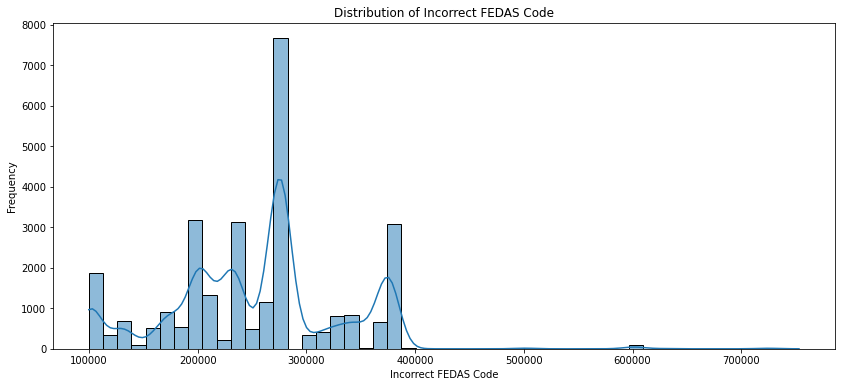

In [5]:
plt.figure(figsize=(14, 6))
sns.histplot(df['incorrect_fedas_code'], bins=50, kde=True)
plt.title('Distribution of Incorrect FEDAS Code')
plt.xlabel('Incorrect FEDAS Code')
plt.ylabel('Frequency')
plt.show()

In [6]:
#Comportement des variables catégorielles. 
df.describe(include='O')

,brand,model_code,model_label,commercial_label,article_main_category,article_type,article_detail,comment,color_code,color_label,inaccurate_gender,country_of_origin,country_of_manufacture,embakment_harbor,size,accurate_gender
count,39322,39322,39322,6238,38571,38402,29622,1552,26677,39308,19692,24920,24920,2773,39322,39322
unique,329,38715,29558,4772,710,1221,4076,134,4399,12907,15,74,78,52,812,11
top,brand_1,813271-40,MAN JEANS,TBT_AP_MN TOP,LOISIRS,HOMME,09-SHOES (LOW),VETEMENT,10776,BLACK,HO,CN,CN,GLEIZE,L,HO
freq,6089,4,86,20,2855,3906,1436,413,1756,2324,6583,6437,8632,518,7448,14775


In [39]:
#Convertissons les Fedas codes en string afin que le modèle les considère comme des variables catégorielles. 
df['incorrect_fedas_code'] = df['incorrect_fedas_code'].astype(str)
df['correct_fedas_code'] = df['correct_fedas_code'].astype(str)

KeyError: 'correct_fedas_code'

29913


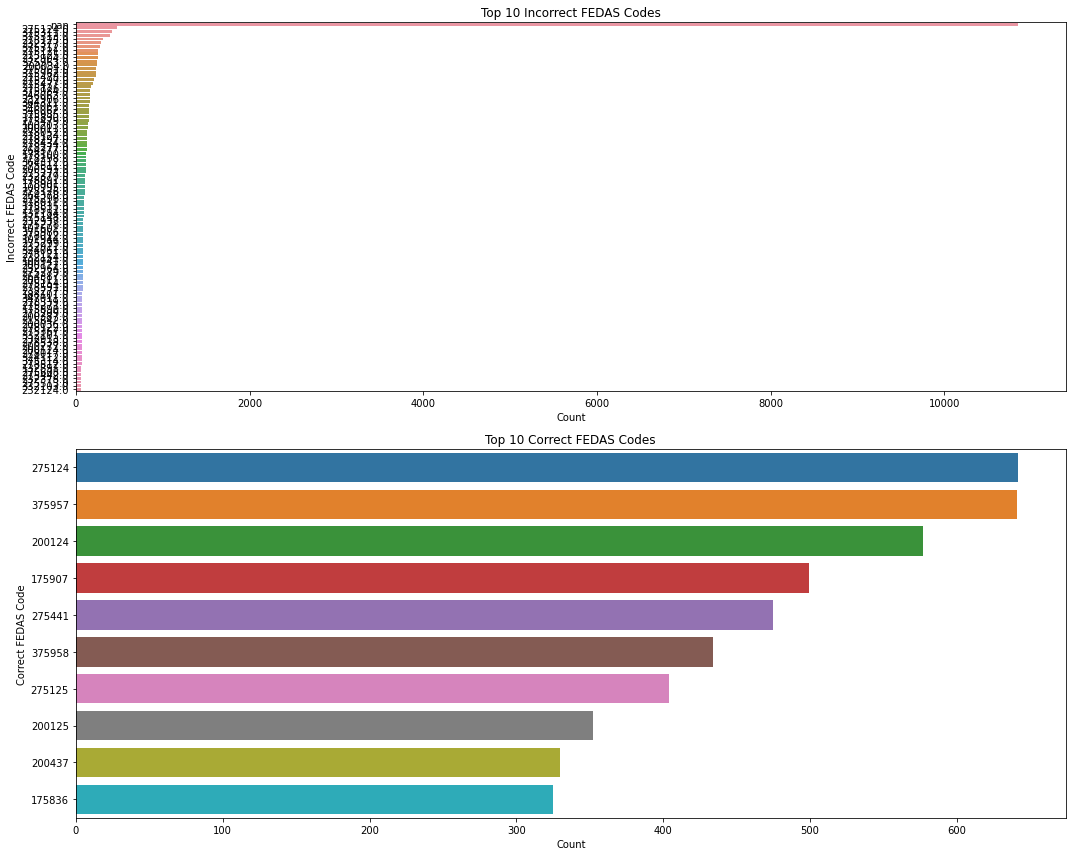

In [9]:
# Visualise la distribution des principaux codes FEDAS pour 'incorrect_fedas_code' et 'correct_fedas_code'

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

# Top 10 incorrect FEDAS codes
top_incorrect = df['incorrect_fedas_code'].value_counts().head(100)
sns.barplot(x=top_incorrect.values, y=top_incorrect.index, ax=ax[0])
ax[0].set_title('Top 10 Incorrect FEDAS Codes')
ax[0].set_xlabel('Count')
ax[0].set_ylabel('Incorrect FEDAS Code')
top_100_fedas_codes = df['correct_fedas_code'].value_counts().head(300).index
print(df[df['correct_fedas_code'].isin(top_100_fedas_codes)].shape[0])

# Top 10 correct FEDAS codes
top_correct = df['correct_fedas_code'].value_counts().head(10)
sns.barplot(x=top_correct.values, y=top_correct.index, ax=ax[1])
ax[1].set_title('Top 10 Correct FEDAS Codes')
ax[1].set_xlabel('Count')
ax[1].set_ylabel('Correct FEDAS Code')

plt.tight_layout()
plt.show()



Nous remarquons une grande cardinalité au sein des variables ainsi au qu'une distribution non équilibrée des variables FEDAS code. 

Regardons quelles variables sont corrélées entre elles et notamment avec la variable cible. 

Text(0.5, 1.0, 'Correlation Heatmap')

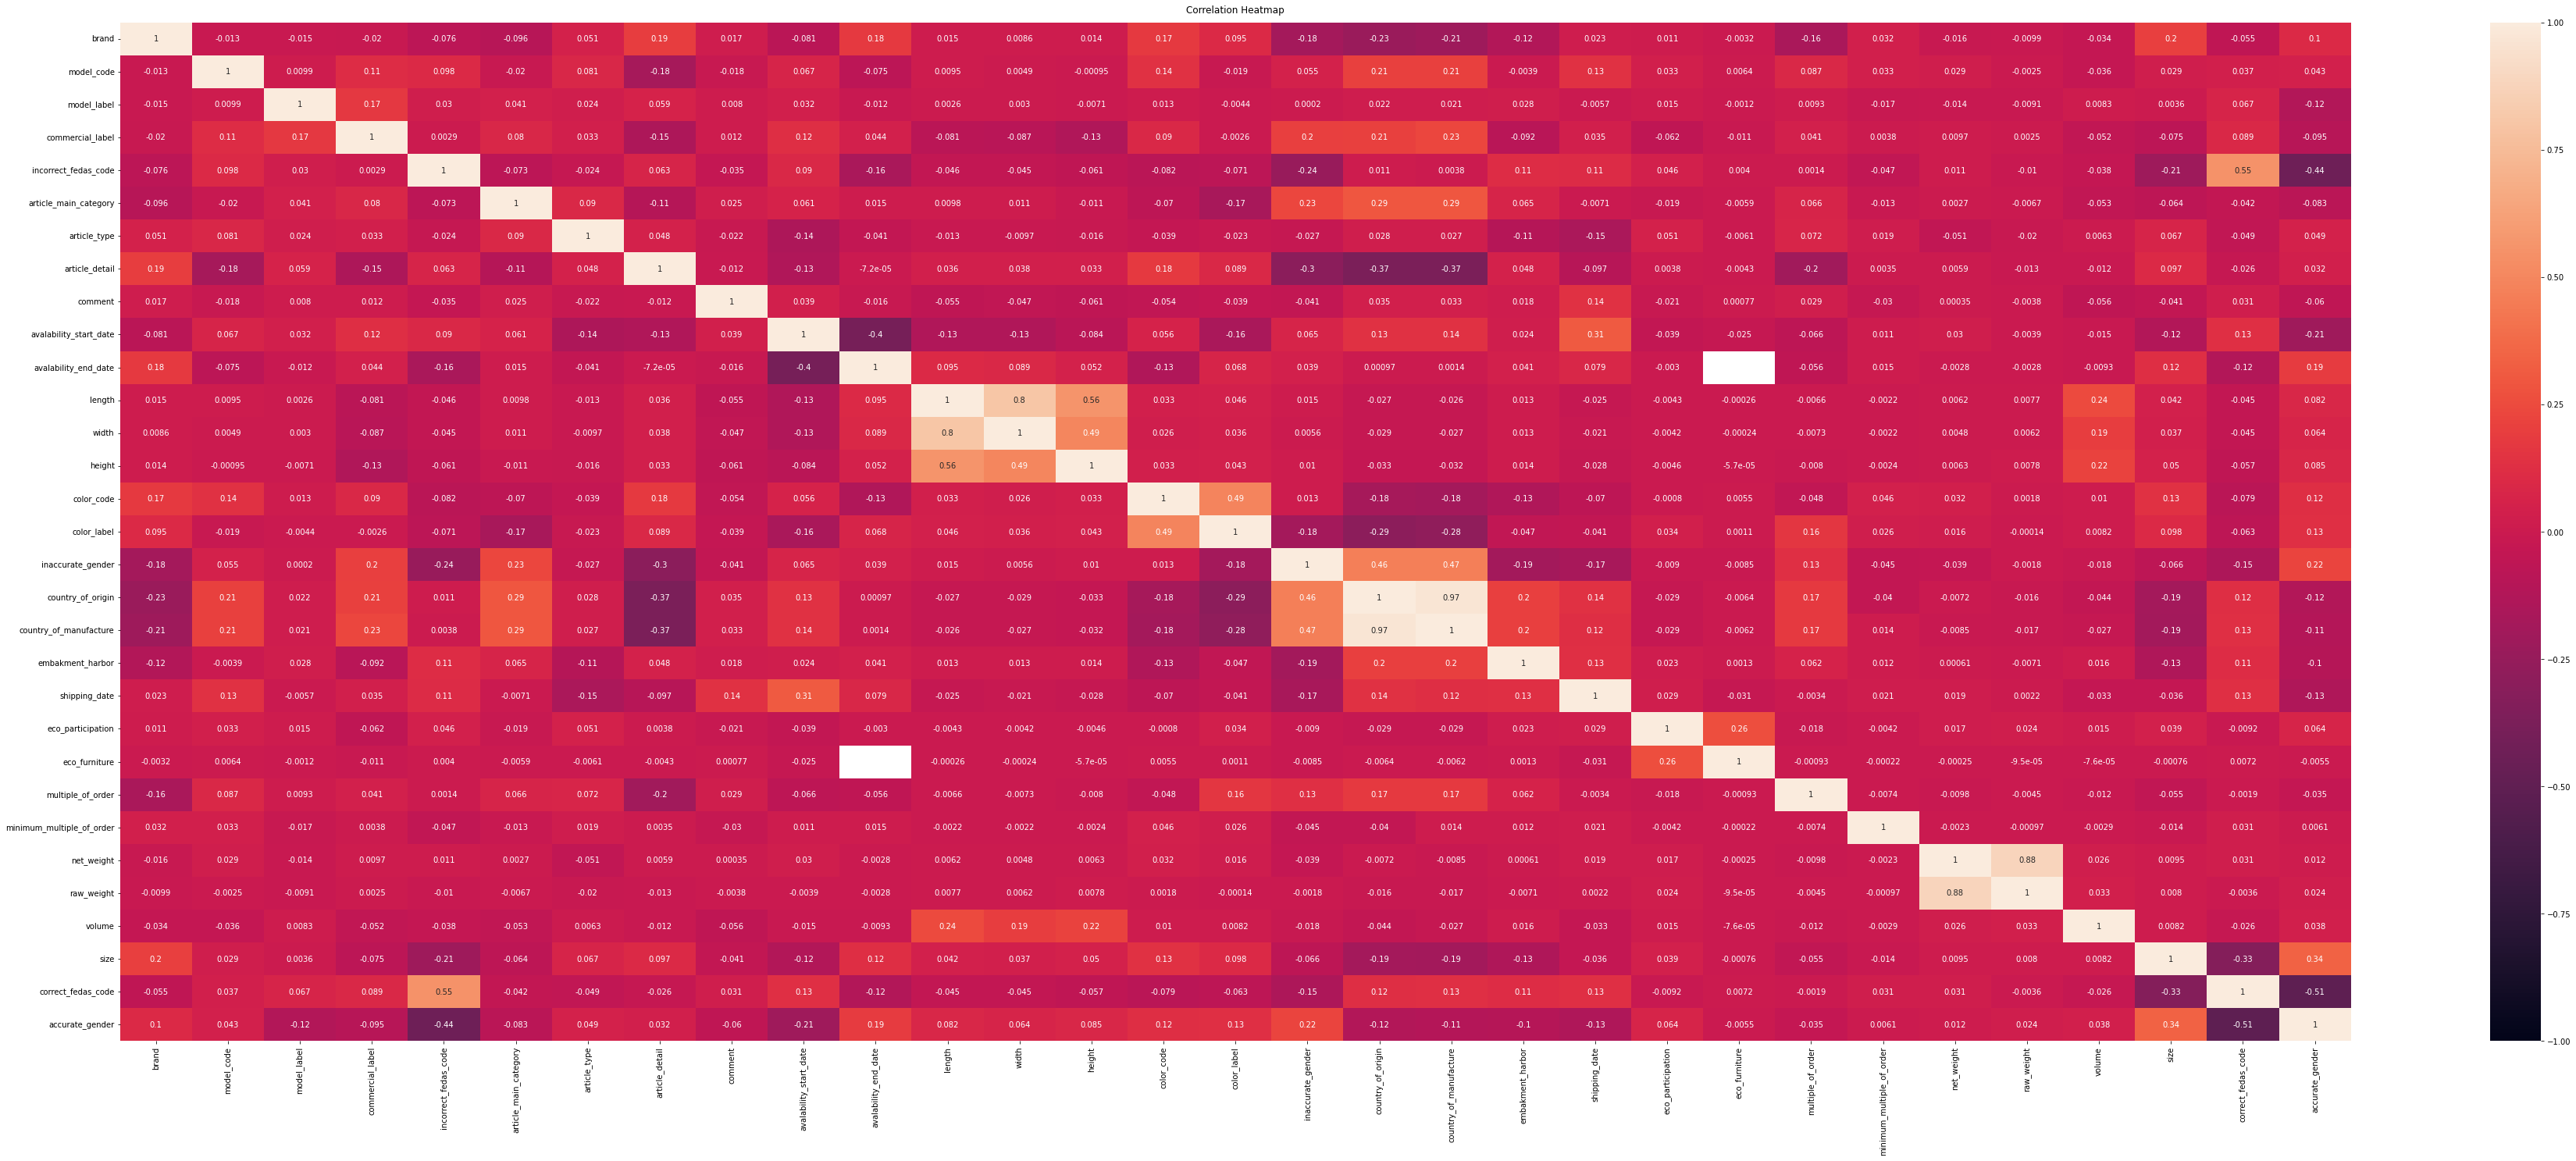

In [9]:
#Copions le jeu de donnée pour éviter que l'encodage ne perdurbe la suite. 
data=df.copy()
# Codage des étiquettes pour les variables catégorielles
for column in data.columns:
    if data[column].dtype == type(object):
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column].astype(str))
plt.figure(figsize=(64, 24))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

On remarque que correct FEDAS CODE est très lié à incorrect FEDAS CODE se qui laisse penser que les mauvais FEDAS CODE sont appliqués selon des règles précises. La variable Size ainsi que AccurateGender est aussi très liée. Nous les prendrons donc en compte. Nous utiliserons d'autres variables avec une faible cardinalité afin de voir si cela n'augmente pas les performances du model. Le mieux serait d'avoir une connaissance métier un peu plus poussée afin de comprendre le lien entre les variables et les Fedas Code.

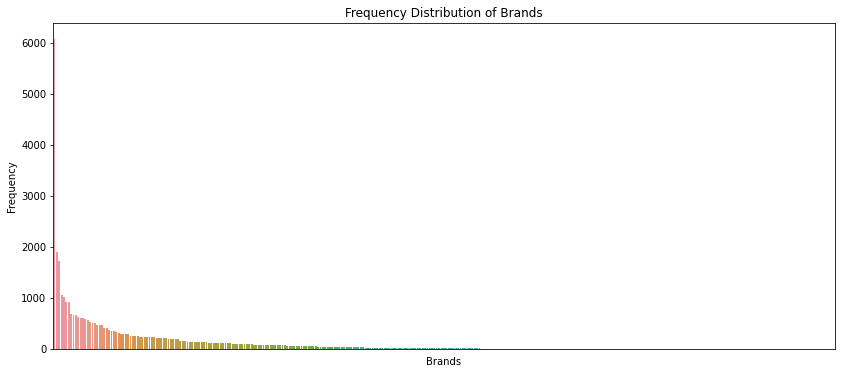

In [10]:
# Visualise la distribution de fréquence des marques
brand_counts = df['brand'].value_counts()

plt.figure(figsize=(14, 6))
sns.barplot(x=brand_counts.index, y=brand_counts.values)
plt.title('Frequency Distribution of Brands')
plt.xlabel('Brands')
plt.ylabel('Frequency')
plt.xticks([])
plt.show()


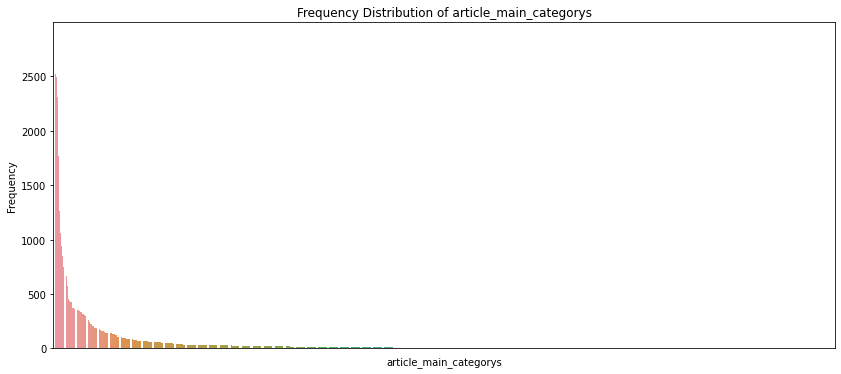

In [11]:
# Visualise la distribution de fréquence des catégories principales d'articles
article_main_category_counts = df['article_main_category'].value_counts()

plt.figure(figsize=(14, 6))
sns.barplot(x=article_main_category_counts.index, y=article_main_category_counts.values)
plt.title('Frequency Distribution of article_main_categorys')
plt.xlabel('article_main_categorys')
plt.ylabel('Frequency')
plt.xticks([])
plt.show()

La répartition des attibuts n'est pas non plus équilibrée. Et certains attributs apparaissent très peu de fois. Travaillons les données pour les rendre utilisables et réduire la Cardinalité. 

#### 2 ) Traitement des variables.  

Pour rendre les variables plus utilisables, nous effectuerons quelques modifications.
Nous travaillerons uniquement sur les variables suivantes :
features = [
'brand_reduced',
'article_main_category_reduced',
'article_type_reduced',
'article_detail_reduced',
'country_of_origin_reduced',
'color_label_reduced',
'incorrect_fedas_code_reduced',
'size', 'accurate_gender'
]

Globalement, toutes les variables sont passées en minuscules et sans espace.

Pour les couleurs, nous essaierons de les regrouper par grande catégorie, comme les couleurs primaires. Avec plus de temps, un prétraitement plus poussé aurait été mieux, notamment utiliser le code couleur pour créer un dictionnaire permettant de regrouper les étiquettes de couleur en fonction de leurs codes couleur associés.

Pour les poids, nous regrouperons les colonnes de poids en une seule afin de réduire le nombre de valeurs manquantes.

Pour le reste, nous effectuerons un prétraitement sur les variables les plus prépondérantes.


In [40]:
# Remplace les 0 par NaN dans les colonnes 'net_weight' et 'raw_weight'
df['net_weight'].replace(0, np.nan, inplace=True)
df['raw_weight'].replace(0, np.nan, inplace=True)
# Recalcule le poids moyen en considérant 0 comme NaN
df['average_weight'] = df[['net_weight', 'raw_weight']].mean(axis=1)
# Affiche les premières lignes du DataFrame, y compris la colonne modifiée et la nouvelle colonne
df[['net_weight', 'raw_weight', 'average_weight']].head()


,net_weight,raw_weight,average_weight
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,0.32,0.45,0.385


In [41]:
def clean_text_column(df, column_name, nan_placeholder='unknown'):
    """
    Clean a text column by converting to lowercase and handling NaN values.
    
    Parameters:
        df (pd.dfFrame): The DataFrame containing the column to clean.
        column_name (str): The name of the column to clean.
        nan_placeholder (str): Placeholder for NaN values.
        
    Returns:
        pd.Series: The cleaned column.
    """
    cleaned_column = df[column_name].str.lower()
    cleaned_column.fillna(nan_placeholder, inplace=True)
    return cleaned_column

def apply_manual_mapping(df, column_name, manual_mapping):
    """
    Apply a manual mapping to a column in the DataFrame.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the column to map.
        column_name (str): The name of the column to map.
        manual_mapping (dict): A dictionary defining the mappings to apply.
        
    Returns:
        pd.Series: The mapped column.
    """
    mapped_column = df[column_name].replace(manual_mapping)
    return mapped_column

# Example Manual Mapping (adjust based on your dataset exploration)
# To create a meaningful mapping, explore the dataset to identify potential mappings. 
# The given mappings are just examples and should be refined based on actual data exploration.
manual_mapping = {
    "homme": "man",
    "men": "man",
    "femme": "woman",
    "women": "woman",
    "loisirs": "leisure",
    "loisir": "leisure",
    "095a  black": "black",
    "bla black": "black",
    "0019 black": "black",
    # Add more mappings as identified from the dataset.
}


def reduce_cardinality(df, column_name, coverage=0.80, other_category='Other'):
    """
    Reduce the cardinality of a categorical column by grouping lower frequency
    categories into a single 'Other' category.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the column to reduce.
        column_name (str): The name of the column to reduce.
        coverage (float): The desired coverage by the most frequent categories.
        other_category (str): The name of the 'Other' category.
        
    Returns:
        pd.Series: The reduced column.
    """
    value_counts = df[column_name].value_counts()
    cumulative_dist = value_counts.cumsum() / value_counts.sum()
    
    # Choose N such that top N categories cover the desired coverage of the data
    N = cumulative_dist[cumulative_dist <= coverage].shape[0]
    top_N_values = value_counts.head(N).index
    
    # Group lower frequency categories under 'Other' category
    reduced_column = df[column_name].where(df[column_name].isin(top_N_values), other_category)
    return reduced_column

# List of columns to clean
columns_to_clean = [
    'brand', 
    'article_main_category', 
    'article_type',
    'article_detail',
    'country_of_origin', 'incorrect_fedas_code', 'color_label','accurate_gender'
]

# Clean the specified columns
for column in columns_to_clean:
    df[f'{column}_clean'] = clean_text_column(df, column)
    df[f'{column}_mapped'] = clean_text_column(df, f'{column}_clean',manual_mapping)
    df[f'{column}_reduced'] = reduce_cardinality(df, f'{column}_mapped', coverage=1, other_category='Other')



Nous avons créé de nouvelles variables "Reduced" plus clean en enlevant les espaces, passant tout en lower case et en regroupant certaines variables comme "loisir" et "loisirs". 

In [42]:
# Define a list of general colors to retain
general_colors = ["BLACK", "WHITE", "NOIR", "BLANC", "BLEU", "ROUGE", "GREEN", "YELLOW", "RED", "BLUE", "GREY", "GRAY", "BROWN", "PINK"]

# Group specific shades and less frequent colors under 'Other' category
df['color_label_reduced'] = df['color_label'].where(df['color_label'].str.upper().isin(general_colors), 'Other')

# Display the value distribution of the reduced 'color_label' feature
df['color_label_reduced'].value_counts()


Other     35129
BLACK      2274
NOIR        682
BLANC       312
WHITE       296
BLEU        211
ROUGE       157
BLUE         83
RED          51
GREY         45
BROWN        28
GREEN        24
PINK         20
YELLOW        8
GRAY          3
Name: color_label_reduced, dtype: int64

Nous conservons les variables suivantes pour l'algorithme. 
features = [
    'brand_reduced', 
    'article_main_category_reduced', 
    'article_type_reduced',
    'article_detail_reduced',
    'country_of_origin_reduced',
    'color_label_reduced',
    'incorrect_fedas_code_reduced',
    'size', 'accurate_gender'
    ]

#### 3 ) Entrainement du modèle.  

Nous avons testé trois modèles : Un random forest, Xgboost et LGBM. Certaines classes n'ont qu'une occurence, ce qui empêche la stratification. Et a donc empêché l'utilisation de librairies comme Optuna afin de trouver les meilleurs hyperparamètres. Au final nous avons conservé le random forest car il s'agit d'un modèle simple et léger avec des performances globalement équivalentes. La légèreté du modèle est un critère important pour la mise en production. La recherche d'hyperparamètres aurait aussi pu être faite avec une gridsearch classique. Mais dans le cadre de cet exercice, cette recherche est trop longue. Néanmoins le code fonctionne et pourra être testé si on veut gagner un ou deux pourcents de précision. 

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

# Prétraitement des données

# Sélection des caractéristiques pour le modèle
features = [
    'brand_reduced', 
    'article_main_category_reduced', 
    'article_type_reduced',
    'article_detail_reduced',
    'country_of_origin_reduced',
    'color_label_reduced',
    'incorrect_fedas_code_reduced',
    'size', 'accurate_gender'
]

# Encodage des étiquettes pour les variables catégorielles réduites
label_encoders = {}
for feature in features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature].astype(str))
    label_encoders[feature] = le

# Division des données en ensembles d'entraînement et de validation
X = df[features]
y = df['correct_fedas_code']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


# Entraînement du modèle de Forêt Aléatoire
rf_model = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=20, random_state=42)
rf_model.fit(X_train, y_train)

# Prédiction sur l'ensemble de validation
y_pred = rf_model.predict(X_valid)

# Calcul des différents scores
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred, average='weighted')
recall = recall_score(y_valid, y_pred, average='weighted')
f1 = f1_score(y_valid, y_pred, average='weighted')

# Affichage des scores du modèle
print(f"Précision finale du modèle : {accuracy}")
print(f"Précision pondérée finale du modèle : {precision}")
print(f"Rappel pondéré final du modèle : {recall}")
print(f"Score F1 pondéré final du modèle : {f1}")


c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Précision finale du modèle : 0.733630006357279
Précision pondérée finale du modèle : 0.7361532897172376
Rappel pondéré final du modèle : 0.733630006357279
Score F1 pondéré final du modèle : 0.7191681089930217


In [16]:
#Vérification des performances par cross-validation
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores: ", cv_scores)
print("Mean CV accuracy: ", cv_scores.mean())
print("Standard Deviation of CV accuracy: ", cv_scores.std())


c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: 

In [20]:
# J'exporte un data-Frame avec les résultats et leurs labels et les probabilités associées. 
predicted_probas = rf_model.predict_proba(X_valid)
predicted_prob = np.max(predicted_probas , axis=1)

# Créer un DataFrame avec les résultats
results_train = pd.DataFrame({
    'True': y_valid,
    'Predicted': y_pred,
    'Predicted_prob': predicted_prob
})
results_train.to_csv('train_results.csv', index=None)

In [ ]:
# Je crée un dataframe afin d'exporter les précisions par classe avec la fréquence de la classe associée. 
classification_metrics = classification_report(y_valid, y_pred, output_dict=True, zero_division=0)
class_precisions = {str(class_name): metrics['precision'] for class_name, metrics in classification_metrics.items() if isinstance(metrics, dict)}

class_frequencies = y_valid.value_counts().to_dict()
precision_ordered_by_frequency = {class_name: class_precisions.get(str(class_name), 0) for class_name in class_frequencies.keys()}
class_info_df = pd.DataFrame({
    'Class': list(precision_ordered_by_frequency.keys()),
    'Precision': list(precision_ordered_by_frequency.values()),
    'Frequency': list(class_frequencies.values())
})

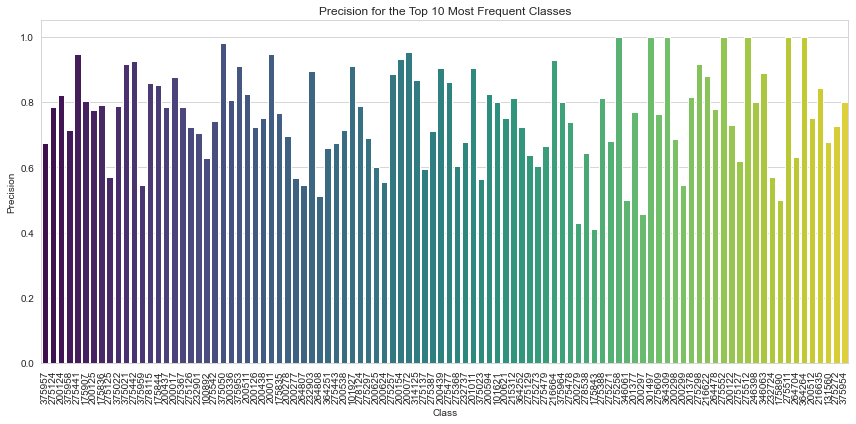

In [ ]:
# Création d'un graphique indiquant la précision pour les 100 classes les plus fréquentes
plt.figure(figsize=(12, 6))
top_10_class_info_df = class_info_df_sorted.head(100)
sns.barplot(x='Class', y='Precision', data=top_10_class_info_df, palette='viridis')
plt.xlabel('Classe')
plt.ylabel('Précision')
plt.title('Précision pour les 10 Classes les Plus Fréquentes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


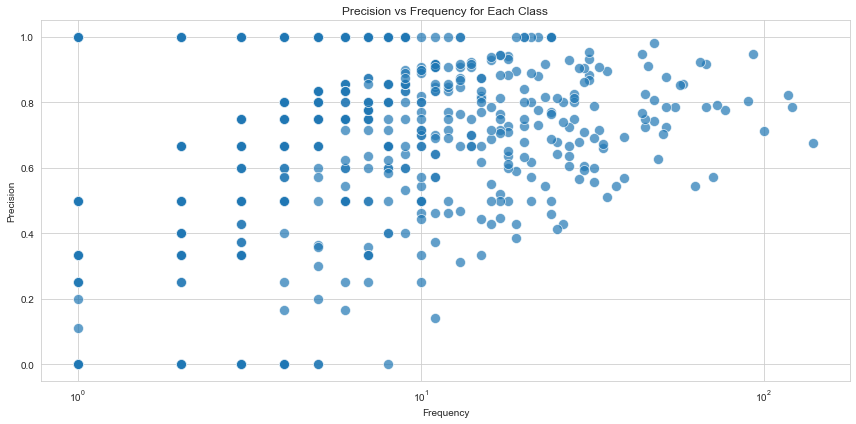

In [ ]:
# Graphique indiquant la précision en fonction de la fréquence. 
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Frequency', y='Precision', data=class_info_df, palette='viridis', s=100, alpha=0.7)
plt.xlabel('Frequency')
plt.ylabel('Precision')
plt.title('Precision vs Frequency for Each Class')
plt.xscale("log")
plt.tight_layout()
plt.show()


Attention ici j'ai entrainé et testé le modèle avec le jeu train. Il faut importer le jeu de test, le préprocess, et le exporter les predictions.  Pour cela il faut run la cellule ci-dessous. Run les cellule de preprocess (commenter les lignes ou il y a 'correct_fedas_code) puis run la cellule encore en dessous. 

In [35]:
#Entrainement du modèle sur l'entièretée du jeu train. 

rf_model = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=20, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, random_state=42)

In [36]:
file_path='test_technical_test.csv'

In [43]:
# Sélection des caractéristiques pour le modèle
features = [
    'brand_reduced', 
    'article_main_category_reduced', 
    'article_type_reduced',
    'article_detail_reduced',
    'country_of_origin_reduced',
    'color_label_reduced',
    'incorrect_fedas_code_reduced',
    'size', 'accurate_gender'
]

# Encodage des étiquettes pour les variables catégorielles réduites
label_encoders = {}
for feature in features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature].astype(str))
    label_encoders[feature] = le

# Division des données en ensembles d'entraînement et de validation
X = df[features]

# J'exporte un data-Frame avec les résultats et leurs labels et les probabilités associées. 
predicted_probas = rf_model.predict_proba(X)
y_pred_test = rf_model.predict(X)
predicted_prob = np.max(predicted_probas , axis=1)

# Créer un DataFrame avec les résultats
results_train = pd.DataFrame({
    'Predicted': y_pred_test,
    'Predicted_prob': predicted_prob
})
results_train.to_csv('test_results.csv', index=None)

Le modèle a une précision satisfaisante sur le jeu de test, d'après les résultats de la validation croisée. Exportons le modèle afin de pouvoir l'utiliser par la suite. On remarque, d'après les graphiques ci-dessus indiquant la précision par classe, que plus la fréquence des classes est faible, moins la précision est fiable. On pourrait donc envisager de ne pas traiter les variables avec une fréquence dans le lot d'entraînement inférieure à 20, car cela introduirait trop de valeurs fausses. Cela permet tout de même de corriger avec une certaine fiabilité un grand nombre de codes FEDAS. 

Ci-dessous j'exporte le modèle afin de l'exploiter en mode production. Aussi je m'attends à une précision de 70% environ sur le jeu de test. Et plus si on enlève les variables à faible occurence. 

In [12]:
from joblib import dump
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

# Sélection des caractéristiques pour le modèle
features = [
    'brand_reduced', 
    'article_main_category_reduced', 
    'article_type_reduced',
    'article_detail_reduced',
    'country_of_origin_reduced',
    'color_label_reduced',
    'incorrect_fedas_code_reduced',
    'size', 'accurate_gender'
]

# Encodage des étiquettes pour les variables catégorielles réduites
label_encoders = {}
for feature in features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature].astype(str))
    label_encoders[feature] = le

# Division des données en ensembles d'entraînement et de validation
X = df[features]
y = df['correct_fedas_code']



# Entraînement du modèle de Forêt Aléatoire
rf_model_export = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=20, random_state=42)
rf_model_export.fit(X, y)


RandomForestClassifier(max_depth=20, random_state=42)

In [14]:
# Prédiction sur l'ensemble de validation
y_pred = rf_model_export.predict(X)

# Calcul des différents scores
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
f1 = f1_score(y, y_pred, average='weighted')

# Affichage des scores du modèle
print(f"Précision finale du modèle : {accuracy}")
print(f"Précision pondérée finale du modèle : {precision}")
print(f"Rappel pondéré final du modèle : {recall}")
print(f"Score F1 pondéré final du modèle : {f1}")

c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Précision finale du modèle : 0.8924266314022684
Précision pondérée finale du modèle : 0.8998416495169193
Rappel pondéré final du modèle : 0.8924266314022684
Score F1 pondéré final du modèle : 0.8890562204102996


In [15]:
#Export du modèle
#Attention modèle lourd. On peut envisager du pruning pour réduire la taille du modèle et éviter d'overfit. Si jamais je trouve
# les perfomances mauvaises sur le jeu de test (inférieur à 60%) 2 pistes sont possibles. Regarder si les liens entre les attributs des
# variables de test et leurs valeurs ne sont pas différents de ceux du jeu d'entrainement. Ici on a fait une hypothèse d'uniformité entre 
# les deux jeux. Si ce n'est pas le cas, test des techniques de régularisation pour simplifier le modèle.  
dump(rf_model_export, 'rf_model.pkl')

['rf_model.pkl']

#### 4) Index.  

Ci-desssous quelques pistes abandonnées car trop chronophages. Il s'agit globalement de bouts de codes mis en place dans d'autres types d'exercices qui m'avaient fournis de bon résultats, mais dans le cas actuel je ne suis pas allé plus loin pour des raison de temps. 

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np

# Selecting features for the model
features = [
    'brand_reduced', 
    'article_main_category_reduced', 
    'article_type_reduced',
    'article_detail_reduced',
    'country_of_origin_reduced',
    'color_label_reduced',
    'incorrect_fedas_code_reduced',
    'size', 'average_weight'
    ]

# Label Encoding for the reduced categorical variables
label_encoders = {}
for feature in features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature].astype(str))
    label_encoders[feature] = le

# Splitting the data into training and validation sets
X = df[features]
y = df['correct_fedas_code']

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a pipeline: imputation, scaling, and Random Forest classifier
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # although no missing values, just to be safe
    ('scaler', StandardScaler()),  # standardize numerical features
    ('rf', RandomForestClassifier(random_state=42))
])

# Define parameter grid for Random Forest
param_grid = {
    'rf__n_estimators': [50, 100, 150],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=10, n_jobs=-1, verbose=1, scoring='accuracy')

# Fit model
grid_search.fit(X_train, y_train)

# Predictions
y_pred_train = grid_search.predict(X_train)
y_pred_test = grid_search.predict(X_test)

# Evaluation
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
best_params = grid_search.best_params_
classification_rep = classification_report(y_test, y_pred_test)

(train_acc, test_acc, best_params, classification_rep)


Fitting 10 folds for each of 108 candidates, totalling 1080 fits


c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Selecting features for the model
features = [
    'brand_reduced', 
    'article_main_category_reduced', 
    'article_type_reduced',
    'article_detail_reduced',
    'country_of_origin_reduced',
    'color_label_reduced',
    'incorrect_fedas_code_reduced',
    'size',
    ]

# Label Encoding for the reduced categorical variables
label_encoders = {}
for feature in features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature].astype(str))
    label_encoders[feature] = le

# Splitting the data into training and validation sets
X = df[features]
y = df['correct_fedas_code']

# Convertir les variables catégorielles en variables numériques
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Paramètres
param = {
    'objective': 'multi:softmax',
    'num_class': len(y.unique()),  # Nombre de classes
    'booster': 'gbtree',
    'max_depth': 50,
    'eval_metric': 'mlogloss',
    'eta': 0.01
}

# Créer des DMatrices
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Entraîner le modèle
bst = xgb.train(param, dtrain, num_boost_round=10, early_stopping_rounds=10, evals=[(dtest, 'eval')], verbose_eval=True)

# Prédire les labels
y_pred = bst.predict(dtest)

# Calculer la précision
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


XGBoostError: [09:19:07] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\multiclass_obj.cu:123: SoftmaxMultiClassObj: label must be in [0, num_class).

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Supposons que df est votre DataFrame et 'target' votre variable cible

# Convertir les variables catégorielles en variables numériques
label_encoded_df = df.copy()
for col in df.select_dtypes(include=['object']).columns:
    label_encoded_df[col], _ = pd.factorize(df[col])

categorical_features = [
    'brand_reduced', 
    'article_main_category_reduced', 
    'article_type_reduced',
    'article_detail_reduced',
    'country_of_origin_reduced',
    'color_label_reduced',
    'incorrect_fedas_code_reduced']

# Diviser les données
X = df[categorical_features]
y = df['correct_fedas_code']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,)

# Paramètres
param_grid = {
    'objective': ['multi:softmax'],
    'num_class': [len(pd.unique(y))],  # Nombre de classes
    'booster': ['gbtree'],
    'max_depth': [3, 10, 50],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [10, 50, 100]
}
    

# Initialisation du modèle
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Grid Search
grid = GridSearchCV(model, param_grid, cv=3, verbose=2)
grid.fit(X_train, y_train)

# Résultats
print(f"Best parameters: {grid.best_params_}")
print(f"Best CV score: {grid.best_score_}")

# Prédiction avec le meilleur modèle
y_pred = grid.best_estimator_.predict(X_test)

# Calculer la précision
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END booster=gbtree, learning_rate=0.01, max_depth=3, n_estimators=10, num_class=1468, objective=multi:softmax; total time=   0.0s
[CV] END booster=gbtree, learning_rate=0.01, max_depth=3, n_estimators=10, num_class=1468, objective=multi:softmax; total time=   0.0s
[CV] END booster=gbtree, learning_rate=0.01, max_depth=3, n_estimators=10, num_class=1468, objective=multi:softmax; total time=   0.0s
[CV] END booster=gbtree, learning_rate=0.01, max_depth=3, n_estimators=50, num_class=1468, objective=multi:softmax; total time=   0.0s
[CV] END booster=gbtree, learning_rate=0.01, max_depth=3, n_estimators=50, num_class=1468, objective=multi:softmax; total time=   0.0s
[CV] END booster=gbtree, learning_rate=0.01, max_depth=3, n_estimators=50, num_class=1468, objective=multi:softmax; total time=   0.0s
[CV] END booster=gbtree, learning_rate=0.01, max_depth=3, n_estimators=100, num_class=1468, objective=multi:softmax; total time= 

ValueError: 
All the 81 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [   0    1    2 ... 1338 1339 1340], got [   0    1    2 ... 1460 1462 1467]

--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [   0    1    2 ... 1333 1334 1335], got [   0    1    2 ... 1462 1465 1467]

--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [   0    1    2 ... 1331 1332 1333], got [   0    1    2 ... 1462 1465 1467]


In [ ]:
categorical_features = [
    'brand_reduced', 
    'article_main_category_reduced', 
    'article_type_reduced',
    'article_detail_reduced',
    'country_of_origin_reduced',
    'color_label_reduced',
    'incorrect_fedas_code_reduced']

# Diviser les données
X = df[categorical_features]
y = df['correct_fedas_code']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




def objective(trial):
    # Define parameter space
    param = {
        'objective': 'multi:softmax',
        'num_class': len(y.unique()),
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
    }

    if param['booster'] == 'gbtree' or param['booster'] == 'dart':
        param['max_depth'] = trial.suggest_int('max_depth', 1, 9)
        param['eta'] = trial.suggest_float('eta', 1e-8, 1.0, log=True)
        param['gamma'] = trial.suggest_float('gamma', 1e-8, 1.0, log=True)
        param['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])

    # Define evaluation metric
    scoring = 'accuracy'

    # Perform cross-validation
    scores = cross_val_score(xgb.XGBClassifier(**param), X, y, cv=3, scoring=scoring)

    # Return mean score
    return scores.mean()

# Initialize study
study = optuna.create_study(direction='maximize')

# Perform optimization
study.optimize(objective, n_trials=50)

# Print best parameters
print(study.best_params)

[I 2023-10-05 01:04:19,623] A new study created in memory with name: no-name-5fc9c9ab-8085-4b72-80c8-b9880f95c018


c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
[W 2023-10-05 01:04:19,907] Trial 0 failed with parameters: {'booster': 'gblinear', 'lambda': 0.5778859511526605, 'alpha': 1.0917864282332344e-07} because of the following error: ValueError('\nAll the 3 fits failed.\nIt is very likely that your model is misconfigured.\nYou can try to debug the error by setting error_score=\'raise\'.\n\nBelow are more details about the failures:\n--------------------------------------------------------------------------------\n1 fits failed with the following error:\nTraceback (most recent call last):\n  File "c:\\Users\\mathi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\sklearn\\model_selection\\_validation.py", line 732, in _fit_and_score\n    estimator.fit(X_train, y_train, **fit_params)\n  File "c:\\Users\\ma

ValueError: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [   0    1    2 ... 1396 1397 1398], got [   0    1    2 ... 1463 1465 1467]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [   0    1    2 ... 1395 1396 1397], got [   0    1    2 ... 1465 1466 1467]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [   0    1    2 ... 1384 1385 1386], got [   0    1    2 ... 1464 1466 1467]
